In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
np.random.seed(23)
pd.set_option('display.max_columns', None)

C:\Users\natal\AppData\Local\Temp\ipykernel_11892\729211821.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
mobile_modelling = pd.read_csv('../Data/Data_modelling/mobile_modelling.csv')

X = mobile_modelling.iloc[:, 0:-1]
y = mobile_modelling.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

mobile_df = pd.concat([X_train, y_train], axis=1)

print(mobile_df.shape)

(980, 21)


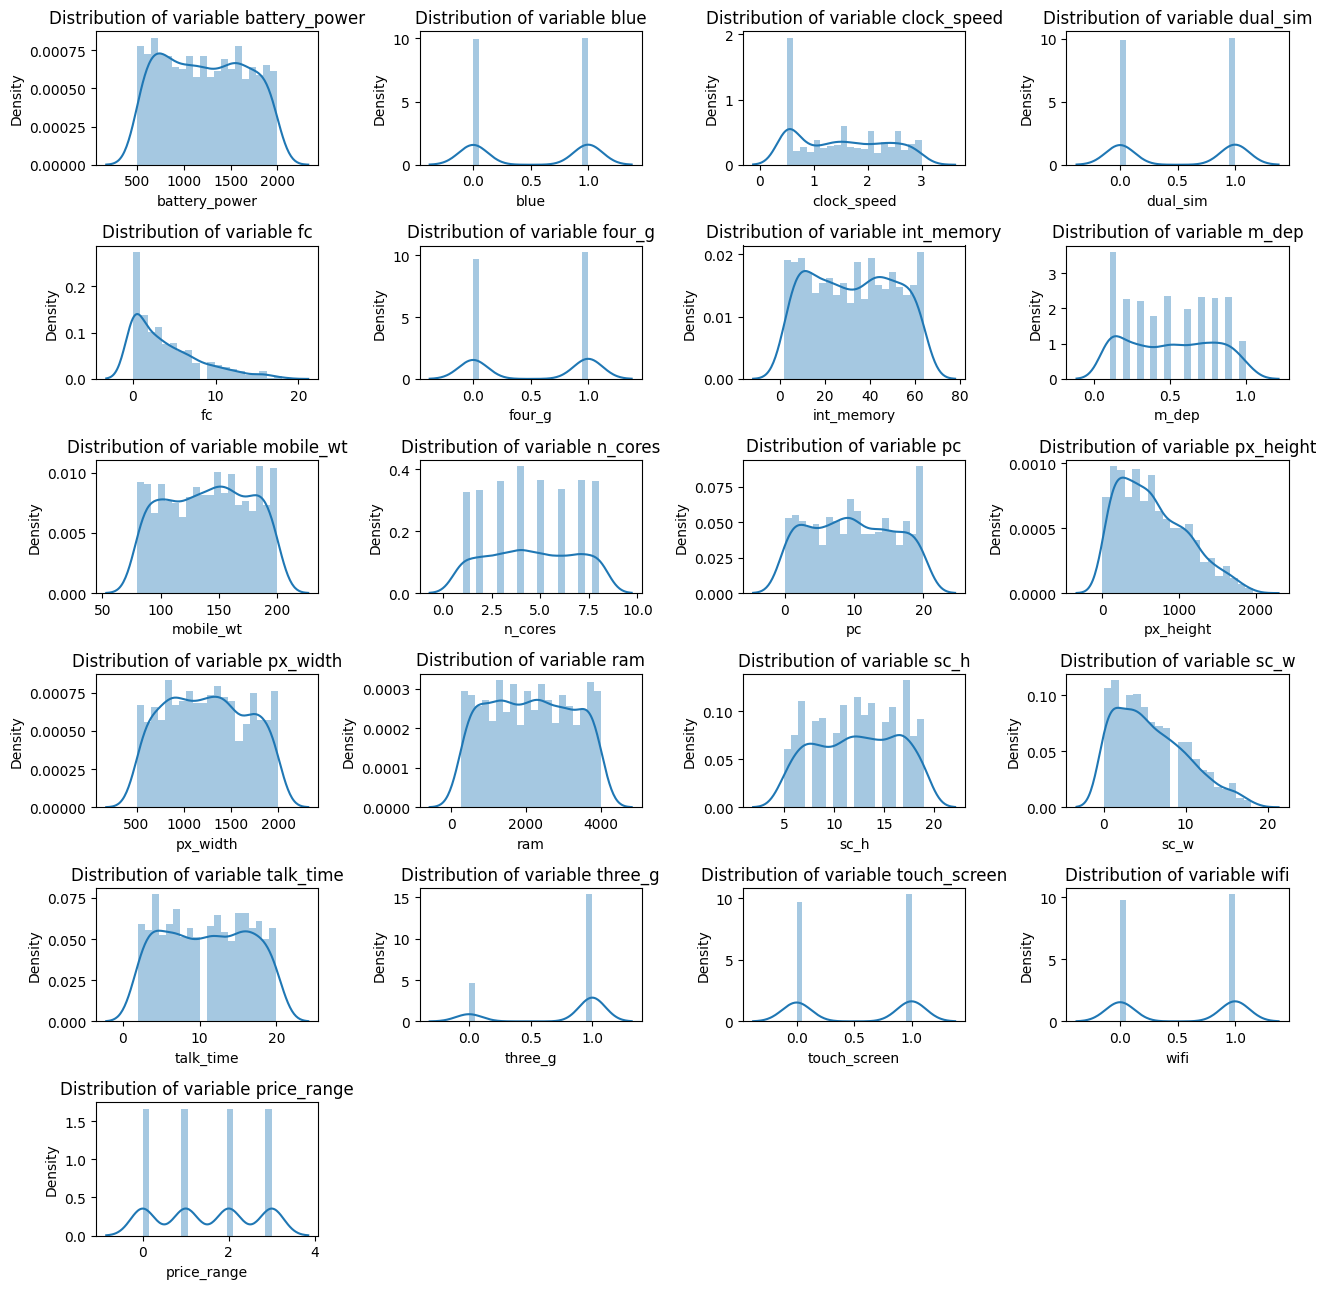

In [3]:
r = 6
c = 4

plt.figure(figsize=(13, 13))

for i, column in enumerate(mobile_df.columns):
    plt.subplot(r, c, i+1)
    dis_dist = sns.distplot(mobile_df[column], bins=20)
    dis_dist.set_title(f'Distribution of variable {column}')  

plt.tight_layout() 
plt.show()

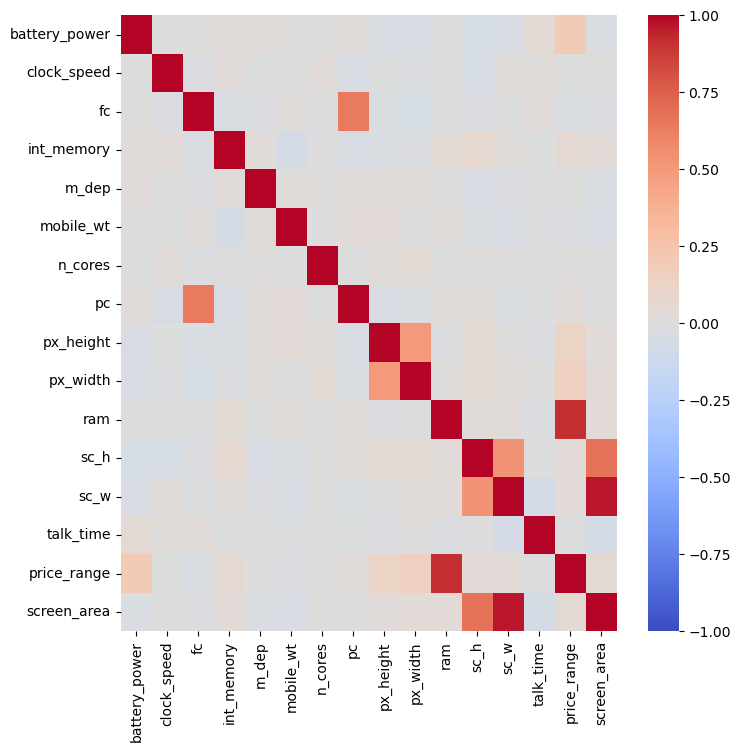

In [23]:
all_columns = mobile_df.columns
columns_binary = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
selected_columns = [col for col in all_columns if col not in columns_binary]
non_binary_df = mobile_df[selected_columns]
non_binary_df['screen_area'] = non_binary_df['sc_h'] * non_binary_df['sc_w']

corr = non_binary_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, cmap='coolwarm', fmt=".2f")
plt.show()

# 1. Feature engineering

### Missing values

We don't have a problem with missing values, but we have 2 columns in which we have records with the value of 0, what doesn't make sense:

The first one is **px_height**. There is 1 record with the value of 0. So we decided to remove it from our dataset.

The second one is **sc_w**. In this case we have 124 records with a value of 0. Removing this amount of records could have an influence on our data and predictions. This is why we decided to try to replace missing values with a mean value from this column in dataset.


In [ ]:
print("px_height with value of 0:")
print((mobile_df['px_height'] == 0).sum())

print("sc_w with value of 0:")
print((mobile_df['sc_w'] == 0).sum())

px_height with value of 0:
1
sc_w with value of 0:
94


In [4]:
mean_sc_w = mobile_df[mobile_df['sc_w'] != 0]['sc_w'].mean()
mobile_df['sc_w'] = mobile_df['sc_w'].replace(0, mean_sc_w)

- **encoding categorical variables**

    In our dataset we don't have any categorical variables that need encoding.
- **transforming variables**

    In our opinion, there is no need to transform any of the variables.
- **scaling/standarisation variables**

    Later, we will check if scaling any of the variables will improve accuracy.
- **outliers**

    After removing missing values, we don't observe any outliers in our dataset.


# 2. Preliminary modelling

- Dummy clasifier
- Decision Tree Classifier
- Logistic Regression
- SVC
- Random Forest Classifier

In [5]:
X_train = mobile_df.iloc[:, 0:-1]
y_train = mobile_df.iloc[:, -1]

### Random forest classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
importances = model.feature_importances_
features = X.columns
forest_importances = pd.Series(importances, index=features).sort_values(ascending=False)
forest_importances

ram              0.467112
battery_power    0.076026
px_width         0.057708
px_height        0.055458
mobile_wt        0.039427
int_memory       0.037880
talk_time        0.032190
pc               0.030592
sc_w             0.029553
clock_speed      0.028856
sc_h             0.028498
m_dep            0.026579
n_cores          0.024210
fc               0.023903
touch_screen     0.008145
blue             0.007236
dual_sim         0.007207
four_g           0.007192
wifi             0.006383
three_g          0.005847
dtype: float64

After checking the importance of all the features, we will test models without taking some of the features into consideration.

In [9]:
# more than 0.02
columns_to_drop_1 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g']
X_train_1 = X_train.drop(columns=columns_to_drop_1)
X_val_1 = X_val.drop(columns=columns_to_drop_1)

# more than 0.05
columns_to_drop_2 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g', 'fc', 'n_cores', 'm_dep', 'sc_h', 'clock_speed', 'sc_w', 'pc', 'talk_time', 'int_memory', 'mobile_wt']
X_train_2 = X_train.drop(columns=columns_to_drop_2)
X_val_2 = X_val.drop(columns=columns_to_drop_2)

# just RAM and battery power
X_train_3 = X_train[['ram', 'battery_power']]
X_val_3 = X_val[['ram', 'battery_power']]

# more than 0.032
columns_to_drop_4 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g', 'fc', 'n_cores', 'm_dep', 'sc_h', 'clock_speed', 'sc_w', 'pc', 'talk_time']
X_train_4 = X_train.drop(columns=columns_to_drop_4)
X_val_4 = X_val.drop(columns=columns_to_drop_4)

### Standarisation

We'll also analyse some of the models with using 2 types of dataset transformations:
- Scaling

In our analysis of different models and variable choices, we examined whether scaling the values would improve accuracy. However, we didn't notice any significant improvements. In fact, in some cases, it even made accuracy worse.

- Box Cox transformation

This function adjusts values to look more like a normal distribution, but it only works for positive values. We tested it with the variables px_height and sc_w. However, similar to scaling, it didn't provide any useful outcomes.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [12]:
# more than 0.02
columns_to_drop_1 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g']
X_train_scaled_1 = X_train_scaled.drop(columns=columns_to_drop_1)
X_val_scaled_1 = X_val_scaled.drop(columns=columns_to_drop_1)

# more than 0.05
columns_to_drop_2 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g', 'fc', 'n_cores', 'm_dep', 'sc_h', 'clock_speed', 'sc_w', 'pc', 'talk_time', 'int_memory', 'mobile_wt']
X_train_scaled_2 = X_train_scaled.drop(columns=columns_to_drop_2)
X_val_scaled_2 = X_val_scaled.drop(columns=columns_to_drop_2)

# just RAM and battery power
X_train_scaled_3 = X_train_scaled[['ram', 'battery_power']]
X_val_scaled_3 = X_val_scaled[['ram', 'battery_power']]

# more than 0.032
columns_to_drop_4 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g', 'fc', 'n_cores', 'm_dep', 'sc_h', 'clock_speed', 'sc_w', 'pc', 'talk_time']
X_train_scaled_4 = X_train_scaled.drop(columns=columns_to_drop_4)
X_val_scaled_4 = X_val_scaled.drop(columns=columns_to_drop_4)

## Dummy Clasifier

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dc = DummyClassifier(strategy='uniform')
dc.fit(X_train,y_train)
y_pred = dc.predict(X_val)
print('most_frequent:')
print(classification_report(y_val, y_pred))

dc = DummyClassifier(strategy='stratified')
dc.fit(X_train,y_train)
y_pred = dc.predict(X_val)
print('stratified:')
print(classification_report(y_val, y_pred))


most_frequent:
              precision    recall  f1-score   support

           0       0.17      0.18      0.17        73
           1       0.29      0.30      0.29        74
           2       0.20      0.21      0.20        73
           3       0.19      0.18      0.18        74

    accuracy                           0.21       294
   macro avg       0.21      0.21      0.21       294
weighted avg       0.21      0.21      0.21       294

stratified:
              precision    recall  f1-score   support

           0       0.20      0.16      0.18        73
           1       0.30      0.28      0.29        74
           2       0.25      0.25      0.25        73
           3       0.26      0.32      0.29        74

    accuracy                           0.26       294
   macro avg       0.25      0.25      0.25       294
weighted avg       0.25      0.26      0.25       294



As we can observe the accuracy of this model is pretty low, so we decided not to check if any further changes will affect it since we believe we will not be able to achieve satisfactory results.

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

# all
model = LogisticRegression(multi_class="ovr")
model.fit(X_train, y_train)
y_pred = dc.predict(X_val)

print('Result for all columns:')
print(classification_report(y_val, y_pred))

# all standarised
model = LogisticRegression(multi_class="ovr")
model.fit(X_train_scaled, y_train)
y_pred = dc.predict(X_val_scaled)

print('Result for all columns, standaraised:')
print(classification_report(y_val, y_pred))

# over 0.02
model.fit(X_train_1, y_train)
y_pred_1 = dc.predict(X_val_1)

print('Result for features with importance greater than 0.02:')
print(classification_report(y_val, y_pred_1))

# over 0.02 standarised
model = LogisticRegression(multi_class="ovr")
model.fit(X_train_scaled_1, y_train)
y_pred = dc.predict(X_val_scaled_1)

print('Result for features with importance greater than 0.02, standaraised:')
print(classification_report(y_val, y_pred))

# over 0.032
model.fit(X_train_4, y_train)
y_pred_4 = dc.predict(X_val_2)

print('Result for features with importance greater than 0.032:')
print(classification_report(y_val, y_pred_4))

# over 0.032 standarised
model = LogisticRegression(multi_class="ovr")
model.fit(X_train_scaled_4, y_train)
y_pred = dc.predict(X_val_scaled_4)

print('Result for features with importance greater than 0.032, standaraised:')
print(classification_report(y_val, y_pred))

# over 0.05
model.fit(X_train_2, y_train)
y_pred_2 = dc.predict(X_val_2)

print('Result for features with importance greater than 0.05:')
print(classification_report(y_val, y_pred_2))

# over 0.05 standarised
model = LogisticRegression(multi_class="ovr")
model.fit(X_train_scaled_2, y_train)
y_pred = dc.predict(X_val_scaled_2)

print('Result for features with importance greater than 0.05, standaraised:')
print(classification_report(y_val, y_pred))

# just ram and battery
model.fit(X_train_3, y_train)
y_pred_3 = dc.predict(X_val_3)

print('Result just for RAM an battery power:')
print(classification_report(y_val, y_pred_3))

# just ram and battery standarised
model.fit(X_train_scaled_3, y_train)
y_pred_3 = dc.predict(X_val_scaled_3)

print('Result just for RAM an battery power, standarised:')
print(classification_report(y_val, y_pred_3))

Result for all columns:
              precision    recall  f1-score   support

           0       0.25      0.26      0.25        73
           1       0.29      0.24      0.26        74
           2       0.28      0.32      0.29        73
           3       0.25      0.24      0.25        74

    accuracy                           0.27       294
   macro avg       0.27      0.27      0.26       294
weighted avg       0.27      0.27      0.26       294

Result for all columns, standaraised:
              precision    recall  f1-score   support

           0       0.24      0.27      0.25        73
           1       0.17      0.16      0.17        74
           2       0.26      0.26      0.26        73
           3       0.22      0.20      0.21        74

    accuracy                           0.22       294
   macro avg       0.22      0.22      0.22       294
weighted avg       0.22      0.22      0.22       294

Result for features with importance greater than 0.02:
             

In this case results are also not satisfactory. The best score is obtained when considering all features from the dataset (the mocst accurately for price range 2).

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier,plot_tree #export_graphviz

# all
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred = tree.predict(X_val)
print('Result for all columns:')
print(classification_report(y_val, y_pred))

# all standarasied
tree.fit(X_train_scaled, y_train)
y_pred_5= tree.predict(X_val_scaled)
print('Result for all columns, standaraised:')
print(classification_report(y_val, y_pred_5))

# over 0.02
tree.fit(X_train_1,y_train)
y_pred_1= tree.predict(X_val_1)
print('Result for features with importance greater than 0.02:')
print(classification_report(y_val, y_pred_1))

# over 0.02 standarised
tree.fit(X_train_scaled_1,y_train)
y_pred_6= tree.predict(X_val_scaled_1)
print('Result for features with importance greater than 0.02, standarised:')
print(classification_report(y_val, y_pred_6))

# over 0.032
tree.fit(X_train_4,y_train)
y_pred_4= tree.predict(X_val_4)
print('Result for features with importance greater than 0.032:')
print(classification_report(y_val, y_pred_4))

# over 0.032 standarised
tree.fit(X_train_scaled_4,y_train)
y_pred_7= tree.predict(X_val_scaled_4)
print('Result for features with importance greater than 0.032, standarised:')
print(classification_report(y_val, y_pred_7))

# over 0.05
tree.fit(X_train_2,y_train)
y_pred_2= tree.predict(X_val_2)
print('Result for features with importance greater than 0.05:')
print(classification_report(y_val, y_pred_2))

# over 0.05 standarised
tree.fit(X_train_scaled_2,y_train)
y_pred_8= tree.predict(X_val_scaled_2)
print('Result for features with importance greater than 0.05, standarised:')
print(classification_report(y_val, y_pred_8))

# just ram and battery power
tree.fit(X_train_3, y_train)
y_pred_3= tree.predict(X_val_3)
print('Result just for RAM an battery power:')
print(classification_report(y_val, y_pred_3))

# just ram and battery power standarised
tree.fit(X_train_scaled_3, y_train)
y_pred_9= tree.predict(X_val_scaled_3)
print('Result just for RAM an battery power, standarised:')
print(classification_report(y_val, y_pred_9))


Result for all columns:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        73
           1       0.72      0.76      0.74        74
           2       0.72      0.73      0.72        73
           3       0.89      0.88      0.88        74

    accuracy                           0.81       294
   macro avg       0.81      0.81      0.81       294
weighted avg       0.81      0.81      0.81       294

Result for all columns, standaraised:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        73
           1       0.76      0.70      0.73        74
           2       0.72      0.71      0.72        73
           3       0.88      0.88      0.88        74

    accuracy                           0.81       294
   macro avg       0.81      0.81      0.81       294
weighted avg       0.81      0.81      0.81       294

Result for features with importance greater than 0.02:
             

As we can see we started to get better results. The best accuracy is obtained for features with importance greater than 0.05. We can also see that in our case standarisation slightly increases the accuracy score but only a tiny bit and only in cases where we delete some of the columns. In our data we do not really have many variables which distribiutuion resembles standard distrubiution, so that is probably the reason why we do not see better results.

# SVM

In [17]:
from sklearn.svm import SVC
svm = SVC()

# all
svm.fit(X_train,y_train)
y_pred = svm.predict(X_val)
print('Result for all columns:')
print(classification_report(y_val, y_pred))

# all, standarised
svm.fit(X_train_scaled,y_train)
y_pred = svm.predict(X_val_scaled)
print('Result for all columns, standarised:')
print(classification_report(y_val, y_pred))

# over 0.02
svm.fit(X_train_1,y_train)
y_pred = svm.predict(X_val_1)
print('Result for features with importance greater than 0.02:')
print(classification_report(y_val, y_pred))

# over 0.02 standarised
svm.fit(X_train_scaled_1,y_train)
y_pred = svm.predict(X_val_scaled_1)
print('Result for features with importance greater than 0.02, standarised:')
print(classification_report(y_val, y_pred))

# over 0.032
svm.fit(X_train_4,y_train)
y_pred = svm.predict(X_val_4)
print('Result for features with importance greater than 0.032:')
print(classification_report(y_val, y_pred))

# over 0.032 standarised
svm.fit(X_train_scaled_4,y_train)
y_pred = svm.predict(X_val_scaled_4)
print('Result for features with importance greater than 0.032, standarised:')
print(classification_report(y_val, y_pred))

# over 0.05
svm.fit(X_train_2,y_train)
y_pred = svm.predict(X_val_2)
print('Result for features with importance greater than 0.05:')
print(classification_report(y_val, y_pred))

# over 0.05 standarised
svm.fit(X_train_scaled_2,y_train)
y_pred = svm.predict(X_val_scaled_2)
print('Result for features with importance greater than 0.05, standarised:')
print(classification_report(y_val, y_pred))

# just ram and battery power
svm.fit(X_train_3,y_train)
y_pred = svm.predict(X_val_3)
print('Result just for RAM and battery power:')
print(classification_report(y_val, y_pred))

# just ram and battery power standarised
svm.fit(X_train_scaled_3,y_train)
y_pred = svm.predict(X_val_scaled_3)
print('Result just for RAM and battery power, standarised:')
print(classification_report(y_val, y_pred))

Result for all columns:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        73
           1       0.89      0.95      0.92        74
           2       0.94      0.88      0.91        73
           3       0.96      0.99      0.97        74

    accuracy                           0.94       294
   macro avg       0.94      0.94      0.94       294
weighted avg       0.94      0.94      0.94       294

Result for all columns, standarised:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        73
           1       0.76      0.76      0.76        74
           2       0.74      0.77      0.75        73
           3       0.94      0.89      0.92        74

    accuracy                           0.84       294
   macro avg       0.84      0.84      0.84       294
weighted avg       0.84      0.84      0.84       294

Result for features with importance greater than 0.02:
              

Considering all columns we can observe great accuracy while for standarised columns, in all cases, the accuracy decreases. Again the best results can be observed for features with importance greater than 0.05 (the most accuracate predictions for price range 1).

# Random Forrest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

# all
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
print('Result for all columns:')
print(classification_report(y_val, y_pred))

# all standarised
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_val_scaled)
print('Result for all columns, standarised:')
print(classification_report(y_val, y_pred))

# over 0.02
model = RandomForestClassifier(random_state=42)
model.fit(X_train_1,y_train)
y_pred_1 = model.predict(X_val_1)
print('Result for features with importance greater than 0.02:')
print(classification_report(y_val, y_pred_1))

# over 0.02 standarised
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled_1,y_train)
y_pred_6 = model.predict(X_val_scaled_1)
print('Result for features with importance greater than 0.02, standarised:')
print(classification_report(y_val, y_pred_6))

# over 0.032
model = RandomForestClassifier(random_state=42)
model.fit(X_train_4,y_train)
y_pred_4 = model.predict(X_val_4)
print('Result for features with importance greater than 0.032:')
print(classification_report(y_val, y_pred_4))

# over 0.032 standarised
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled_4,y_train)
y_pred_7 = model.predict(X_val_scaled_4)
print('Result for features with importance greater than 0.032, standarised:')
print(classification_report(y_val, y_pred_7))

# over 0.05
model.fit(X_train_2,y_train)
y_pred_2 = model.predict(X_val_2)
print('Result for features with importance greater than 0.05:')
print(classification_report(y_val, y_pred_2))

# over 0.05 standarised
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled_2,y_train)
y_pred_8 = model.predict(X_val_scaled_2)
print('Result for features with importance greater than 0.05, standarised:')
print(classification_report(y_val, y_pred_8))

# ram and battery
model.fit(X_train_4,y_train)
y_pred_5 = model.predict(X_val_4)
print('Result just for RAM and battery power:')
print(classification_report(y_val, y_pred_5))

# ram and battery standarised
model.fit(X_train_scaled_4,y_train)
y_pred_9 = model.predict(X_val_scaled_4)
print('Result just for RAM and battery power, standarised:')
print(classification_report(y_val, y_pred_9))

Result for all columns:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        73
           1       0.76      0.80      0.78        74
           2       0.74      0.71      0.73        73
           3       0.92      0.91      0.91        74

    accuracy                           0.84       294
   macro avg       0.84      0.84      0.84       294
weighted avg       0.84      0.84      0.84       294

Result for all columns, standarised:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        73
           1       0.75      0.74      0.75        74
           2       0.75      0.73      0.74        73
           3       0.92      0.92      0.92        74

    accuracy                           0.83       294
   macro avg       0.83      0.83      0.83       294
weighted avg       0.83      0.83      0.83       294

Result for features with importance greater than 0.02:
              

The accuracy for this model is pretty good. In this case we observe the best accuracy for features with importance greater than 0.032, with importance greater than 0.05, standarised (better with price range 1 and 2, worse with 3 and 4) and, what might be surprising, just for RAM and battery power.

# Summary

- We obtained the best accuracy for SVM model while considering features with importance greater than 0.05.
- Overall SVM model seems to give the best results from all tested and it works better without a process of standarisation. 
- Stanadarisation had positively influenced Decision Tree model and partially in Logistic Regression model.
- Removing columns in most of the cases had positive inflence on the results.
- There is no pattern for deciding which columns should be removed, since we can observe that for different models we get the best results for different set of features used for training.